In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import os
from pathlib import Path

# Scikit-learn Utilities
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score
# Note: train_test_split dihapus karena data sudah dipisah manual

# Konfigurasi Tampilan
%matplotlib inline
sns.set_style('whitegrid')

# --- 1. KONFIGURASI PATH (Anti-Leakage) ---
current_dir = Path(os.getcwd())
PROJECT_DIR = current_dir.parents[2] 

# Mengarah ke folder hasil split manual (processed_correct)
DATA_DIR = PROJECT_DIR / 'data' / 'processed_correct'
TRAIN_FILE = DATA_DIR / 'train_features.csv'
TEST_FILE  = DATA_DIR / 'test_features.csv'
MLRUNS_DIR = PROJECT_DIR / 'mlruns' 

print(f"📂 Posisi Notebook: {current_dir}")
print(f"📂 Project Root   : {PROJECT_DIR}")
print(f"📂 MLflow Path    : {MLRUNS_DIR}")
print(f"📄 Train File     : {TRAIN_FILE}")
print(f"📄 Test File      : {TEST_FILE}")

# --- 2. SETUP MLFLOW ---
if not MLRUNS_DIR.exists():
    MLRUNS_DIR.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(f"file:///{MLRUNS_DIR.as_posix()}")
# Ganti nama eksperimen agar hasil model jujur tidak tercampur dengan yang lama
mlflow.set_experiment("Roodio_Mood_SVM_Experiment_LeakageFree")

# --- 3. LOAD DATA (TRAIN & TEST TERPISAH) ---
if not TRAIN_FILE.exists() or not TEST_FILE.exists():
    print(f"\n[ERROR] File CSV tidak ditemukan di: {DATA_DIR}")
    raise FileNotFoundError("Dataset Training/Testing hilang!")

df_train = pd.read_csv(TRAIN_FILE)
df_test  = pd.read_csv(TEST_FILE)

print(f"\n📊 Data Train: {df_train.shape}")
print(f"📊 Data Test : {df_test.shape} (Unseen Data)")

# --- 4. PREPROCESSING ---
# Hapus kolom label dan filename (jika ada)
drop_cols = ['label']
if 'filename' in df_train.columns:
    drop_cols.append('filename')

X_train = df_train.drop(columns=drop_cols, errors='ignore')
y_train_raw = df_train['label']

X_test = df_test.drop(columns=drop_cols, errors='ignore')
y_test_raw = df_test['label']

# Encode Label
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw) # Transform data test pakai encoder training

label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(f"✅ Label Mapping: {label_mapping}")
print("✅ Setup Selesai. Siap Training SVM (Tanpa Leakage).")

📂 Posisi Notebook: c:\CAWU4GROUP3\projects\projectRoodio\machineLearning\src\models\audioModel
📂 Project Root   : c:\CAWU4GROUP3\projects\projectRoodio\machineLearning
📂 MLflow Path    : c:\CAWU4GROUP3\projects\projectRoodio\machineLearning\mlruns
📄 Train File     : c:\CAWU4GROUP3\projects\projectRoodio\machineLearning\data\processed_correct\train_features.csv
📄 Test File      : c:\CAWU4GROUP3\projects\projectRoodio\machineLearning\data\processed_correct\test_features.csv

📊 Data Train: (1601, 158)
📊 Data Test : (156, 158) (Unseen Data)
✅ Label Mapping: {0: 'angry', 1: 'happy', 2: 'relaxed', 3: 'sad'}
✅ Setup Selesai. Siap Training SVM (Tanpa Leakage).


c:\Users\andiz\anaconda3\envs\roodio-env\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


🚀 Sedang Melatih SVM (Mungkin butuh waktu)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Training Selesai!
🏆 Parameter Terbaik : {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
📊 Akurasi Final     : 0.6218
⚖️ F1-Score (Macro)  : 0.6142


2026/02/02 22:15:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\andiz\anaconda3\envs\roodio-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


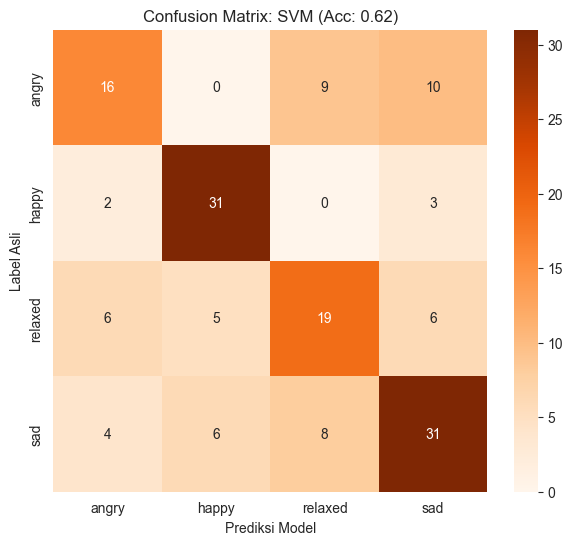

💾 Hasil SVM tersimpan lengkap di MLflow.


In [2]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score

# --- 1. DEFINISI PIPELINE ---
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

# --- 2. GRID SEARCH PARAMETER ---
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# --- 3. EKSEKUSI TRAINING ---
run_name = "SVM_Tuning_Notebook"

with mlflow.start_run(run_name=run_name):
    print("🚀 Sedang Melatih SVM (Mungkin butuh waktu)...")
    
    grid = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    
    # --- 4. EVALUASI ---
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_model.predict(X_test)
    
    # Hitung Metrik Lengkap
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='macro')
    test_prec = precision_score(y_test, y_pred, average='macro')
    test_recall = recall_score(y_test, y_pred, average='macro')
    
    print(f"\n✅ Training Selesai!")
    print(f"🏆 Parameter Terbaik : {best_params}")
    print(f"📊 Akurasi Final     : {test_acc:.4f}")
    print(f"⚖️ F1-Score (Macro)  : {test_f1:.4f}")
    
    # --- 5. LOGGING KE MLFLOW ---
    # Log Params
    clean_params = {k.replace("classifier__", ""): v for k, v in best_params.items()}
    mlflow.log_params(clean_params)
    
    # Log Metrics
    mlflow.log_metrics({
        "accuracy": test_acc,
        "f1_macro": test_f1,
        "precision_macro": test_prec,
        "recall_macro": test_recall
    })
    
    # Log Classification Report (Text File)
    report_text = classification_report(y_test, y_pred, target_names=le.classes_)
    with open("classification_report.txt", "w") as f:
        f.write(report_text)
    mlflow.log_artifact("classification_report.txt")
    if os.path.exists("classification_report.txt"): os.remove("classification_report.txt")

    # Log Model
    signature = mlflow.models.infer_signature(X_train, best_model.predict(X_train))
    mlflow.sklearn.log_model(best_model, "model", signature=signature, input_example=X_train.iloc[:1])
    
    # --- 6. VISUALISASI CM ---
    plt.figure(figsize=(7,6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix: SVM (Acc: {test_acc:.2f})')
    plt.ylabel('Label Asli')
    plt.xlabel('Prediksi Model')
    
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.show()
    if os.path.exists("confusion_matrix.png"): os.remove("confusion_matrix.png")
    
    print("💾 Hasil SVM tersimpan lengkap di MLflow.")


📊 LAPORAN EVALUASI SVM
              precision    recall  f1-score   support

       angry       0.57      0.46      0.51        35
       happy       0.74      0.86      0.79        36
     relaxed       0.53      0.53      0.53        36
         sad       0.62      0.63      0.63        49

    accuracy                           0.62       156
   macro avg       0.61      0.62      0.61       156
weighted avg       0.62      0.62      0.62       156

----------------------------------------
🏆 Macro F1-Score : 0.6142
🎯 Macro Precision: 0.6143
----------------------------------------


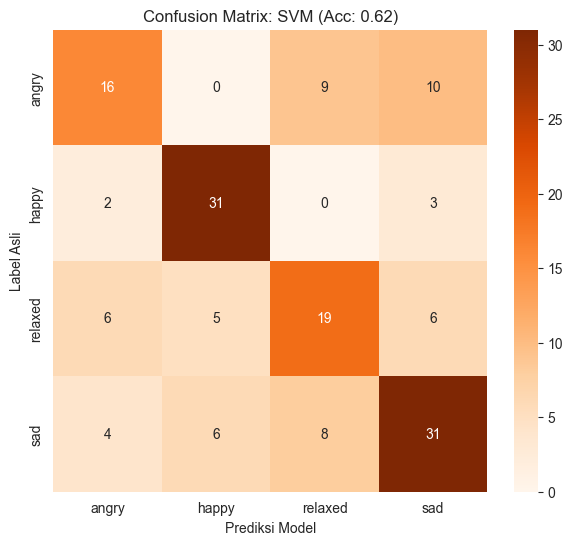

⚠️ KESALAHAN TERBESAR:
SVM sering salah mengira 'angry' sebagai 'sad' (10 kasus).


In [3]:
# --- EVALUASI SVM ---
print("\n" + "="*40)
print("📊 LAPORAN EVALUASI SVM")
print("="*40)

# 1. Classification Report
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

# 2. Metrik Global (Macro Avg)
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_prec = precision_score(y_test, y_pred, average='macro')

print("-" * 40)
print(f"🏆 Macro F1-Score : {macro_f1:.4f}")
print(f"🎯 Macro Precision: {macro_prec:.4f}")
print("-" * 40)

# 3. Analisis Kesalahan
cm = confusion_matrix(y_test, y_pred)

# Plot Heatmap
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix: SVM (Acc: {test_acc:.2f})')
plt.ylabel('Label Asli')
plt.xlabel('Prediksi Model')
plt.show()

# Cek Kesalahan Terbesar
np.fill_diagonal(cm, 0) 
max_error_idx = np.unravel_index(np.argmax(cm), cm.shape)
true_label_err = le.classes_[max_error_idx[0]]
pred_label_err = le.classes_[max_error_idx[1]]
count_err = cm[max_error_idx]

print(f"⚠️ KESALAHAN TERBESAR:")
print(f"SVM sering salah mengira '{true_label_err}' sebagai '{pred_label_err}' ({count_err} kasus).")